# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Data Engineering and Machine Learning Operations in Business** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Feature transformations.
3. Training datasets creation - splitting into train, validation and test sets.
4. Loading the training data.
5. Training the model.
6. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

In [1]:
# Importing the packages for the needed libraries for the Jupyter notebook
import inspect 
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store

In [2]:
# Importing the hopsworks module
import hopsworks

# Logging in to the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556180
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

# forecast_renewable_energy_fg = fs.get_feature_group(
#     name='forecast_renewable_energy',
#     version=1
# )

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in part 01 we can now join them together for the `electricity_fg`, `forecast_renewable_energy_fg`, `weather_fg` and `danish_holiday_fg` .

In [4]:
# Select features for training data
selected_features_training = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour"]), join_type="inner")\
    .join(danish_calendar_fg.select_all(), join_type="inner")

In [5]:
## .join(forecast_renewable_energy_fg.select_except(["timestamp", "time"]))\

In [7]:
# Uncomment this if you would like to view your selected features
selected_features_training.show(5)

Finished: Reading data from Hopsworks, using ArrowFlight (3.24s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,holiday
0,1682280000000,2023-04-23 20:00:00+00:00,2023-04-23,20,1.02178,10.4,74.0,0.0,0.0,0.0,3.0,100.0,7.6,10.1,6,23,4,2023,1
1,1678816800000,2023-03-14 18:00:00+00:00,2023-03-14,18,0.77461,0.5,88.0,0.0,0.0,0.0,0.0,0.0,11.6,22.7,1,14,3,2023,0
2,1697259600000,2023-10-14 05:00:00+00:00,2023-10-14,5,-0.01551,9.8,71.0,0.0,0.0,0.0,1.0,23.0,29.5,54.7,5,14,10,2023,1
3,1657170000000,2022-07-07 05:00:00+00:00,2022-07-07,5,1.15795,15.0,90.0,0.1,0.1,0.0,51.0,59.0,16.6,31.3,3,7,7,2022,0
4,1647597600000,2022-03-18 10:00:00+00:00,2022-03-18,10,1.48754,8.4,60.0,0.0,0.0,0.0,0.0,0.0,21.9,45.4,4,18,3,2022,0


`Feature Views` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create a **Training Dataset**.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

We can specify next parameters:

- `name` - name of the feature group.

- `version` - version of the feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with the data.

In [8]:
# Getting or creating a feature view named 'electricity_feature_view'
version = 1 # Defining the version for the feature view
feature_view_training = fs.get_or_create_feature_view(
    name='electricity_training_feature_view',
    version=version,
    query=selected_features_training,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/556180/fs/552003/fv/electricity_training_feature_view/version/1


## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

Training dataset is created using `fs.create_training_dataset()` method.

**From feature view APIs you can also create training datasts based on even time filters specifing `start_time` and `end_time`** 

In [9]:
X, _ = feature_view_training.training_data(
    description = 'Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (2.98s) 


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20437 entries, 0 to 20436
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             20437 non-null  int64  
 1   datetime              20437 non-null  object 
 2   date                  20437 non-null  object 
 3   hour                  20437 non-null  int32  
 4   dk1_spotpricedkk_kwh  20437 non-null  float64
 5   temperature_2m        20437 non-null  float64
 6   relative_humidity_2m  20437 non-null  float64
 7   precipitation         20437 non-null  float64
 8   rain                  20437 non-null  float64
 9   snowfall              20437 non-null  float64
 10  weather_code          20437 non-null  float64
 11  cloud_cover           20437 non-null  float64
 12  wind_speed_10m        20437 non-null  float64
 13  wind_gusts_10m        20437 non-null  float64
 14  dayofweek             20437 non-null  int32  
 15  day                

### <span style="color:#2656a3;"> 🤖 Transformation Functions</span>

We preprocess our data using *min-max scaling* on the numerical features and *label encoding* on the one categorical feature we have.
To achieve this, we create a mapping between our features and transformation functions. This ensures that transformation functions like min-max scaling are applied exclusively on the training data, preventing any data leakage into the validation or test sets.

To achieve this, we create a mapping between our features and transformation functions - ved ikke om man kan sige det her?

In [11]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder object
# label_encoder = LabelEncoder()

# # Fit the encoder to the data in the 'city_name' column
# label_encoder.fit(X[['type']])

# # Transform the 'city_name' column data using the fitted encoder
# encoded = label_encoder.transform(X[['type']])

In [12]:
# # Convert the output of the label encoding to a dense array and concatenate with the original data
# X = pd.concat([X, pd.DataFrame(encoded)], axis=1)

# Drop columns 'date', 'city_name', 'unix_time' from the DataFrame 'X'
X = X.drop(columns=['date', 'datetime', 'timestamp'])

# # Rename the newly added column with label-encoded city names to 'city_name_encoded'
# X = X.rename(columns={0: "type_encoded"})

In [13]:
# Extract the target variable 'pm2_5' from the DataFrame 'X' and assigning it to the variable 'y'
y = X.pop('dk1_spotpricedkk_kwh')

### <span style="color:#2656a3;"> ⛳️ Dataset with train, test and validation splits</span>

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
)

In [15]:
X_train.head()

,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,holiday
11019,17,4.1,82.0,0.0,0.0,0.0,0.0,8.0,18.1,33.1,1,19,12,2023,0
11025,9,18.9,84.0,1.5,1.5,0.0,61.0,100.0,12.1,25.6,0,10,7,2023,0
2974,12,-0.4,73.0,0.0,0.0,0.0,3.0,86.0,19.8,39.6,3,30,11,2023,0
15581,7,1.1,94.0,0.0,0.0,0.0,0.0,0.0,8.4,14.0,2,2,3,2022,0
7811,15,14.0,47.0,0.0,0.0,0.0,3.0,100.0,15.9,33.8,6,23,4,2023,1


In [16]:
y_train.head()

11019    0.63267
11025    0.87877
2974     1.45548
15581    2.44737
7811     0.25863
Name: dk1_spotpricedkk_kwh, dtype: float64

## <span style="color:#2656a3;">🧬 Modeling</span>

For Modeling we initialize the XGBoost Regressor.

XGBoost Regressor is a powerful and versatile algorithm known for its effectiveness in a wide range of regression tasks, including predictive modeling and time series forecasting.

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os

In [18]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor()

In [19]:
# Train the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#ff5f27'> ⚖️ Model Validation

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [21]:
# Predict target values on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("⛳️ MSE:", mse)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("⛳️ RMSE:", rmse)

# Calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("⛳️ R^2:", r2)

# Calculate Mean Absolute Error (MAE) using sklearn
mae = mean_absolute_error(y_test, y_pred)
print("⛳️ MAE:", mae)

⛳️ MSE: 0.05780723509825844
⛳️ RMSE: 0.24043135215328812
⛳️ R^2: 0.9314774344000265
⛳️ MAE: 0.16206161460052418


## <span style="color:#2656a3;">🔧 Fine tuning</span>

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [23]:
params = {
    # TODO: we could parametrize data prep too and test some combinations
    # TODO: check params for search grid
    'xgb__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgb__max_depth': [3, 4, 5, 6],
    'xgb__min_child_weight': [0.5, 1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.001, 0.1, 0.2 , 0.3, 0.4],
    'xgb__colsample_bytree': [0.5, 0.7, 0.9, 1, 1.5, 2],
}

In [24]:
gs_xgb = RandomizedSearchCV(estimator=model, param_distributions=params, verbose=3, cv=5, n_jobs=-1)

In [25]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [26]:
# Train the fine tuned model on the training data
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.5, 0.7, 0.9,
                                                                  1, 1.5, 2],
                                        'xgb__gamma': [0.0, 0.001, 0.1, 0.2,
                                                       0.3, 0.4],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'xgb__max_depth': [3, 4, 5, 6],
                                        'xgb__min_child_weight': [0.5, 1, 3, 5,
                                                                  7]},
                   verbose=3)

In [27]:
# Display the best parameters and the best score obtained from the RandomizedSearchCV
display(gs_xgb.best_params_)
display(gs_xgb.best_score_)

{'xgb__min_child_weight': 0.5,
 'xgb__max_depth': 3,
 'xgb__learning_rate': 0.1,
 'xgb__gamma': 0.4,
 'xgb__colsample_bytree': 1}

0.9274642500956365

In [28]:
# Make predictions on the validation set
gs_model = gs_xgb.best_estimator_

In [29]:
# Get predictions for test set to get a performance estimate for unseen data
# Best model is already re-trained on whole training data! (default for refit=True)
y_pred2 = gs_model.predict(X_test)
mean_error = mean_absolute_error(y_test, y_pred2)
display(mean_error)

0.16206161460052418

In [30]:
# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred2)
print("⛳️ MSE:", mse)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred2, squared=False)
print("⛳️ RMSE:", rmse)

# Calculate R squared using sklearn
r2 = r2_score(y_test, y_pred2)
print("⛳️ R^2:", r2)

# Calculate Mean Absolute Error (MAE) using sklearn
mae = mean_absolute_error(y_test, y_pred2)
print("⛳️ MAE:", mae)

⛳️ MSE: 0.05780723509825844
⛳️ RMSE: 0.24043135215328812
⛳️ R^2: 0.9314774344000265
⛳️ MAE: 0.16206161460052418


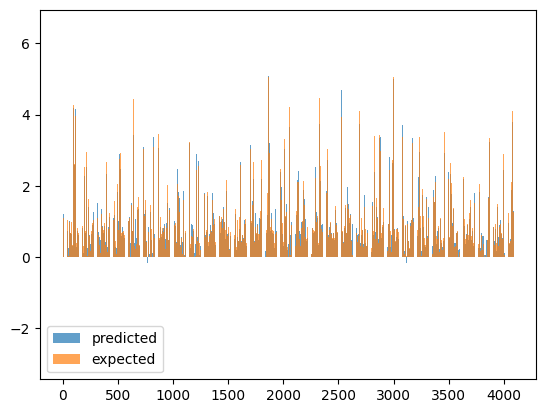

In [31]:
# Plot the predictions against the expected values
plt.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
plt.bar(x=np.arange(len(y_pred)), height=y_test, label='expected', alpha=0.7)
plt.legend()
plt.show() 

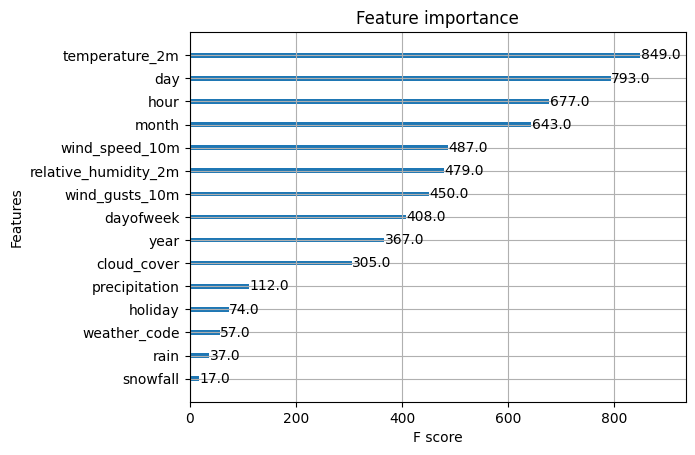

In [32]:
# Import the plot_importance function from XGBoost
from xgboost import plot_importance

# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    model, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

## <span style='color:#2656a3'>🗄 Model Registry</span>

In [33]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

In [34]:
# Retrieving the Model Registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>

In [35]:
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

In [36]:
# Exporting the trained model to a directory
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [37]:
# Save the XGBoost regressor as joblib file in the model directory
joblib.dump(model, model_dir + "/dk_electricity_model.pkl")

['model/dk_electricity_model.pkl']

In [38]:
# Create an entry in the model registry that includes the model's name, desc, metrics
xgb_model = mr.python.create_model(
    name="electricity_price_prediction_model",
    metrics={
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2,
        "MAE": mae,
    },
    model_schema=model_schema,
    input_example=X_train.sample(),
    description="DK1 Electricity Price Predictor"
)

In [39]:
# Upload to hopsworks
xgb_model.save(model_dir)

Uploading: 100.000%|██████████| 465147/465147 elapsed<00:02 remaining<00:00  3.60it/s]
Uploading: 100.000%|██████████| 82/82 elapsed<00:01 remaining<00:0002<00:05,  1.42s/it]
Uploading: 100.000%|██████████| 1344/1344 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/556180/models/electricity_price_prediction_model/1


Model(name: 'electricity_price_prediction_model', version: 1)

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

Next notebook we will use the registered model to make predictions based on the batch data.